In [1]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import TextElement
from mesa.datacollection import DataCollector
import random

In [2]:
#global seed
# Set a global seed
global_seed = 100
random.seed(global_seed)
np.random.seed(global_seed)

In [3]:
class AgentCountElement(TextElement):
    def __init__(self):
        pass

    def render(self, model):
        agents_count = model.schedule.get_type_count(Non_corrupt_agent)
        sugar_agents_count = model.schedule.get_type_count(Sugar)
        return f"Non Corrupt Agents: {agents_count} | Sugar Agents: {sugar_agents_count}"

class AverageWealthElement(TextElement):
    def render(self, model):
        # Calculate the average wealth of alive corrupt agents
        agents = [agent for agent in model.schedule.agents_by_type[Non_corrupt_agent].values()]
        if agents:
            average_wealth = sum(agent.sugar_agent for agent in agents) / len(agents)
        else:
            average_wealth = 0
        return f"Average Wealth of Agents: {average_wealth:.2f}"

In [4]:
# Helper functions

# Calculate the Euclidean distance between cells
def distance(dist1, dist2):
    x1, y1 = dist1
    x2, y2 = dist2
    dist_x = x1 - x2
    dist_y = y1 - y2

    dist = math.sqrt((dist_x ** 2) + (dist_y ** 2))
    return dist

In [5]:
#This is a class for sugar patches. Each sugar patch is treated as an agent
class Sugar(mesa.Agent):
    def __init__(self, unique_id, model, position, sugar_capacity):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patche in the grid
        self.curr_amount = sugar_capacity #the current amount of sugar in a patch. Can be reduced if an agent eats the sugar
        self.sugar_capacity = sugar_capacity #maximum sugar for a patch
        self.step_counter = 0  # Counter for steps

    #The step function is going to add one unit of sugar per step until sugar is at its maximum capacity
    def step(self):
        #self.step_counter += 1
        #if self.step_counter % 2 == 0:
        self.curr_amount = min([self.sugar_capacity, self.curr_amount + 1])
        #self.curr_amount = min([self.sugar_capacity, 10])
        #print(self.unique_id, self.curr_amount, self.sugar_capacity)

In [6]:
#Class for corrupt agents
class Non_corrupt_agent(mesa.Agent):
    def __init__(self, unique_id, model, position, moore = False, sugar_agent = 0, sugar_metabolism = 0, sugar_vision = 0):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patch in the grid
        self.moore = moore
        self.sugar_agent = sugar_agent
        self.sugar_metabolism = sugar_metabolism
        self.sugar_vision = sugar_vision
        self.shared_with_count = 0  # Counter for tracking sharing actions
        self.share_amount = 0
        self.steal_amount = 0 
        self.share_total = 0
        self.eat_total = 0 
        self.moved = False
        self.dead = False
        self.survival = 0

    #determines if the neigbouring cell is a sugar patch
    def is_sugar(self, position):
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for agent in cell:
            if type(agent) is Sugar: # referes to the sugar class
                return agent
            return None
    
    # Get Sugar amount in the next cell
    def sugar_amount(self, position):
        sugar = self.is_sugar(position)
        if sugar:
            return sugar.curr_amount
        return 0

    def get_neighbours(self, position):
        '''
        This is a helper function for share_with_neighbours()
        '''
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position 
        
        for agent in cell:
            if isinstance(agent, Non_corrupt_agent): #if cell has corrupt agent
                return agent
    
    # the following function helps move() to determine if a cell has been occupied
    def cell_occupied(self, position):
        if position == self.position: # Agents are allowed to stay in the same position
           return False #not occupied
        # Now we cater for a situation in which a cell is occupied
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for j in cell: #going through all neihgbourhoot cells
            if isinstance(j, Non_corrupt_agent): #if cell has corrupt agent
                return True
        return False

    # This function calculates welfares non corrupt_agents
    def calculate_welfare(self, sugar):
        welfare = sugar/self.sugar_metabolism
        return welfare

    # This function calculates needs of non corrupt_agents
    def calculate_need(self):
        need = self.sugar_agent/self.sugar_metabolism
        return need
    
    # This function etermines whether an agent is starved or not
    def starved(self):
        return (self.sugar_agent <= 0)
    
    def fair_share(self, other):

        # Ensure both agents have sugar to share
        assert self.sugar_agent > 0
        assert other.sugar_agent > 0

        # Calculate the needs of both agents
        need_self = self.calculate_need()
        need_other = other.calculate_need()

        # Share if the other agent's need is greater and the difference in wealth is reasonable
        if need_other > need_self:
            share_amount = self.sugar_agent // 4  # Share half the difference
            self.sugar_agent -= share_amount
            other.sugar_agent += share_amount
            self.shared_with_count += 1
            self.share_total += share_amount
            #print(f"Agent {self.unique_id} has shared a total of {self.share_total}")
            print(f"Agent {other.unique_id} with {need_other} has received {share_amount} from {self.unique_id} with {self.sugar_agent}")
        else:
            # Do nothing if sharing would be unfair or unnecessary
            pass

        
    def calculate_need(self):
        '''
        Calculates the need for sugar based on metabolism and current sugar levels.
        A higher value indicates a greater need.
        '''
        return max(1, self.sugar_metabolism / self.sugar_agent) 
        
    # This function moves agents in the grid
    def move(self, exploration_prob=0.1):
        '''
        #1 Identify possible moves
        #2 Determine move that maximizes welfare
        #3 Find closest best option
        #4 Move
        '''
    
        #1 Identifying possible moves
        neighborhood = [i
                        for i in self.model.grid.get_neighborhood(self.position, self.moore, True, self.sugar_vision)
                        if not self.cell_occupied(i)  # Ensure that multiple corrupt agents are not in the same cell
                        ]
    
        # If the neighborhood is empty, return early
        if not neighborhood:
            return

        #2 Randomly decide whether to explore
        if self.random.random() < exploration_prob:
            # Exploration: Choose a random position from the neighborhood
            cell_final = [self.random.choice(neighborhood)]
        else:
            #3 Determine which neighbors provide maximum welfare
            welfare = [self.calculate_welfare(self.sugar_agent + self.sugar_amount(position)) for position in neighborhood]
            max_welfare = max(welfare)
    
            # Index of max welfare cells
            cell_indices = [i for i in range(len(welfare))
                            if math.isclose(welfare[i], max_welfare, rel_tol=1e-02)
                            ]
    
            # Converting indexes to cell positions
            cell_position = [neighborhood[i] for i in cell_indices]
    
            # Find the closest best option
            shortest_dist = min(distance(self.position, position) for position in cell_position)
            cell_final = [pos for pos in cell_position
                          if math.isclose(distance(self.pos, pos), shortest_dist, rel_tol=1e-02)
                          ]

        # If no valid move is found (e.g., all welfare values are equal), explore randomly
        if not cell_final or cell_final[0] == self.position:
            # Choose a random position from the neighborhood to ensure the agent moves
            cell_final = [self.random.choice(neighborhood)]
    
        self.random.shuffle(cell_final)  # Randomize choice if multiple equal options
    
        if cell_final[0] != self.position:
            self.moved = True
    
        #4 Move agent
        self.model.grid.move_agent(self, cell_final[0])
    
    # This function is for agents to consume resources
    def eat(self):
        sugar_patch = self.is_sugar(self.position)
        if sugar_patch:
            self.sugar_agent += sugar_patch.curr_amount
            self.eat_total += sugar_patch.curr_amount
            print(f"Agent {self.unique_id} has eaten {sugar_patch.curr_amount} sugar from sugar {sugar_patch.unique_id}")
            sugar_patch.curr_amount = 0

    def metabolize(self):
        self.sugar_agent -= self.sugar_metabolism


    # This function kills off agents who have usedup all their sugar
    def agent_die(self):
        if self.dead == False:
                self.survival+=1
        if self.starved():
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            self.model.dead_agents += 1  # Increment the dead agents counter in the model
            self.dead = True
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
        #elif not self.starved():
        #    print(self.unique_id, self.sugar_agent, self.sugar_vision, self.model.schedule.get_type_count(Corrupt_agent))

    #this is the function that corrupt agents will use to share resources
    def share_with_neighbours(self):
        '''
        This will be in three parts:
        1. Identify neighbours to share with
        2. Share with those
        3. Collect data
        ''' 
        
        #Neighbors below help us create a list of agents we can share with
        ##get_neighbours() is ahelper function
        neighbors = [self.get_neighbours(position) for position in self.model.grid.get_neighborhood(self.position, self.moore, False, self.sugar_vision)
                    if self.cell_occupied(position)
                   ]

        if len(neighbors) == 0:
            return [],[] #return 2 empty lists if an agent doesn't have neighbors
        
        #iterate through neighbours and share 
        for i in neighbors:
            if i:
                self.fair_share(i)
  
    

In [12]:
#This class belongs to the main model, the engine of the project.
class Model(mesa.Model):
    def __init__(self, X = 50, Y = 50, init_population = 100, init_resource_min = 10, init_resource_max = 20, metabolism_min = 1, metabolism_max = 5, vision_min = 1, vision_max = 5, seed=None):
        #grid-space width and height 
        self.X = X
        self.Y = Y

        # Set the global seed if provided
        if seed is not None:
            self.seed = seed
            random.seed(self.seed)
            np.random.seed(self.seed)
        
        #initializing population attributes
        self.init_population = init_population
        self.init_resource_min = init_resource_min
        self.init_resource_max = init_resource_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.running = True
        self.dead_agents = 0
        self.cycle = 0

        #initiate mesa grid
        self.grid = mesa.space.MultiGrid(self.X, self.Y, torus = False)
        self.schedule = mesa.time.RandomActivationByType(self) #randomizes the sequence in which agents perform actions
        sugar_distro = np.genfromtxt("random.txt")   
        #plt.imshow(sugar_distro, origin = "lower") #Shows the grid

        # Initialize the DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "Step": lambda model: model.schedule.steps,
                "Agents": lambda model: model.schedule.get_type_count(Non_corrupt_agent),
                "Average Wealth": lambda model: model.avg_wealth()
            },

            agent_reporters = {
                "Unique ID": lambda agent: agent.unique_id if isinstance(agent, Non_corrupt_agent) else 0,
                "Wealth": lambda agent: agent.sugar_agent if isinstance(agent, Non_corrupt_agent) else 0,
                "Survival": lambda agent: agent.survival if isinstance(agent, Non_corrupt_agent) else 0,
                "Collection Efficiency": lambda agent: agent.sugar_vision if isinstance(agent, Non_corrupt_agent) else 0,
                "Consumption": lambda agent: agent.sugar_metabolism if isinstance(agent, Non_corrupt_agent) else 0,
                "Share Amount": lambda agent: agent.share_amount if isinstance(agent, Non_corrupt_agent) else 0,
                "Stolen Amount": lambda agent: agent.steal_amount if isinstance(agent, Non_corrupt_agent) else 0,
                "Moved": lambda agent: agent.moved if isinstance(agent, Non_corrupt_agent) else 0,
                "Total Shared": lambda agent: agent.share_total if isinstance(agent, Non_corrupt_agent) else 0,
                "Total Eaten": lambda agent: agent.eat_total if isinstance(agent, Non_corrupt_agent) else 0,
                "Share count": lambda agent: agent.shared_with_count if isinstance(agent, Non_corrupt_agent) else 0
            }
        )
        
        #The for loop is used to create sugar agents in the grid
        all_agent_id = 0
        for _, (x,y) in self.grid.coord_iter():
            max_sugar = sugar_distro[x,y] #getting sugar levels from the sugar distribution
            if max_sugar > 0:
                sugar_agent = Sugar(all_agent_id, self, (x,y), max_sugar) #creating an a sugar agent
                self.grid.place_agent(sugar_agent, (x,y)) #places an agent in the grid wherever there is a sugar level greater than 0
                self.schedule.add(sugar_agent)
                #print(sugar_agent.unique_id, sugar_agent.position,sugar_agent.sugar_capacity)
                all_agent_id = all_agent_id + 1
        #for _, (x,y) in self.grid.coord_iter():
        #    print(_, (x,y))

        # For loop for creating corrupt agents
        for each in range(self.init_population):
            #placing the polulation at random x y coordinates in the grid
            x = self.random.randrange(self.X)
            y = self.random.randrange(self.Y)

            #uniform distribution of initial resources, vision and metabolism for sugar agents
            sugar_agent = int(self.random.uniform(self.init_resource_min, self.init_resource_max + 1))
            sugar_metabolism = int(self.random.uniform(self.metabolism_min, self.metabolism_max + 1))
            sugar_vision = int(self.random.uniform(self.vision_min, self.vision_max + 1))

            #creating a corrupt agent
            non_corrupt_agent = Non_corrupt_agent(all_agent_id, self, (x,y), moore = False, sugar_agent = sugar_agent, sugar_metabolism = sugar_metabolism, sugar_vision = sugar_vision)

            #place agent in the grid
            self.grid.place_agent(non_corrupt_agent, (x,y))
            self.schedule.add(non_corrupt_agent)
            #print("ID", "Position", "Initial Amount", "Metabolism", "Vision")
            #print(corrupt_agent.unique_id, corrupt_agent.position, corrupt_agent.sugar_agent, corrupt_agent.sugar_metabolism, corrupt_agent.sugar_vision)
            all_agent_id = all_agent_id + 1
            
    def avg_wealth(self):
        """Calculate the average wealth of all living corrupt agents."""
        agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
        if agents:
            average_wealth = sum(agent.sugar_agent for agent in agents) / len(agents)
        else:
            average_wealth = 0
        return average_wealth

    
    # This is a helper function for the step function that randomizes the movement of agents (Which agent oes first) 
    def randomize_agents(self):
        non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
        self.random.shuffle(non_corrupt_agents_shuffle)
        return non_corrupt_agents_shuffle
        
    # What the model does in each step    
    def step(self):
        self.schedule.step()
        # Sugar patch steps
        for sugar_agent in self.schedule.agents_by_type[Sugar].values():
            sugar_agent.step()

        # Corrupt Agents steps
        non_corrupt_agents_shuffle = self.randomize_agents()
        
        for i in non_corrupt_agents_shuffle:
            i.move()
            i.metabolize()
            i.agent_die()

         # Case-like structure based on the cycle counter
        if self.cycle == 0:
            for i in non_corrupt_agents_shuffle:
                i.eat()
                
        elif self.cycle == 1:
            non_corrupt_agents_shuffle = self.randomize_agents() # Re-shuffle after agents have died
            for i in non_corrupt_agents_shuffle:  # Remaining agents after death
                i.share_with_neighbours()
        
        self.datacollector.collect(self)
        self.schedule.steps += 1 # Important for data collector
        self.cycle = (self.cycle + 1) % 2
        
    def run_model(self, step_count):
        for i in range(step_count):
            self.step() 
            print(self.schedule.steps)
            agent_results = self.datacollector.get_agent_vars_dataframe()
            agent_results_filtered = agent_results[agent_results["Unique ID"] >= 2069]
            #print(agent_results_filtered)
            if i == 99 or i == 199:
                agent_results_filtered.to_csv(f"Data/non_corrupt_agent_results_{self.schedule.steps}.csv")

In [13]:
model1 = Model(seed=global_seed)
model1.run_model(step_count = 200)

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\3470171674.py:4: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_4

Agent 2323 has eaten 6.0 sugar from sugar 620
Agent 2312 has eaten 4.0 sugar from sugar 175
Agent 2345 has eaten 9.0 sugar from sugar 94
Agent 2383 has eaten 8.0 sugar from sugar 1315
Agent 2375 has eaten 8.0 sugar from sugar 2159
Agent 2348 has eaten 3.0 sugar from sugar 1504
Agent 2359 has eaten 9.0 sugar from sugar 1261
Agent 2324 has eaten 5.0 sugar from sugar 1174
Agent 2331 has eaten 9.0 sugar from sugar 1615
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2298 has eaten 8.0 sugar from sugar 615
Agent 2338 has eaten 8.0 sugar from sugar 235
Agent 2346 has eaten 7.0 sugar from sugar 1417
Agent 2295 has eaten 7.0 sugar from sugar 441
Agent 2377 has eaten 8.0 sugar from sugar 2208
Agent 2297 has eaten 8.0 sugar from sugar 277
Agent 2364 has eaten 2.0 sugar from sugar 969
Agent 2307 has eaten 10.0 sugar from sugar 1089
Agent 2354 has eaten 9.0 sugar from sugar 2095
Agent 2368 has eaten 5.0 sugar from sugar 1470
Agent 2322 has eaten 7.0 sugar from sugar 584
Agent 2342 has eaten 1.

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2394 with 2.0 has received 2.0 from 2368 with 7.0
Agent 2327 with 2.0 has received 5.0 from 2370 with 16.0
Agent 2312 with 5.0 has received 4.0 from 2370 with 12.0
Agent 2385 with 1.25 has received 2.0 from 2346 with 8.0
Agent 2382 with 1.3333333333333333 has received 6.0 from 2324 with 20.0
Agent 2387 with 5.0 has received 2 from 2351 with 8
Agent 2326 with 1.5 has received 5.0 from 2345 with 18.0
Agent 2371 with 1.5 has received 1.0 from 2390 with 3.0
Agent 2353 with 1.3333333333333333 has received 4.0 from 2308 with 13.0
Agent 2390 with 1.3333333333333333 has received 2.0 from 2360 with 7.0
Agent 2389 with 3.0 has received 6.0 from 2350 with 21.0
12
Agent 2327 has eaten 1.0 sugar from sugar 40
Agent 2372 has eaten 4 sugar from sugar 2042
Agent 2394 has eaten 4 sugar from sugar 1559
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2305 has eaten 4 sugar from sugar 1765
Agent 2392 has eaten 3.0 sugar from sugar 2164
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2387 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2308 has eaten 4 sugar from sugar 916
Agent 2372 has eaten 4 sugar from sugar 2042
Agent 2382 has eaten 3.0 sugar from sugar 1265
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2362 has eaten 4 sugar from sugar 332
Agent 2301 has eaten 4 sugar from sugar 1119
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2368 has eaten 4 sugar from sugar 1470
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2353 has eaten 3.0 sugar from sugar 1002
Agent 2361 has eaten 4 sugar from sugar 1527
Agent 2306 has eaten 4 sugar from sugar 872
Agent 2378 has eaten 1.0 sugar from sugar 1465
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2305 has eaten 4 sugar from sugar 1765
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2295 has eaten 4 sugar from sugar 441
Agent 2381 has eaten 4 sugar from sugar 116
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2372 has eaten 4 sugar from sugar 2042
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2300 has eaten 2.0 sugar from sugar 619
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2314 has eaten 4 sugar from sugar 1340
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2304 has eaten 4 sugar from sugar 1867
Agent 2301 has eaten 4 sugar from sugar 1119
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2368 has eaten 4 sugar from sugar 1470
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2360 has eaten 1.0 sugar from sugar 1183
Agent 2337 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2339 has eaten 4 sugar from sugar 442
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2381 has eaten 4 sugar from sugar 116
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2295 has eaten 4 sugar from sugar 441
Agent 2357 has eaten 4 sugar from sugar 1940
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2355 has eaten 4.0 sugar from sugar 794
Agent 2314 has eaten 4 sugar from sugar 1340
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2321 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2350 has eaten 4 sugar from sugar 670
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2337 has eaten 4 sugar from sugar 162
Agent 2357 has eaten 4 sugar from sugar 1940
Agent 2381 has eaten 4 sugar from sugar 116
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2314 has eaten 4 sugar from sugar 1340
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2372 has eaten 4 sugar from sugar 2042
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2386 has eaten 4 sugar from sugar 427
Agent 2357 has eaten 4 sugar from sugar 1940
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2337 has eaten 4 sugar from sugar 162
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2315 has eaten 1.0 sugar from sugar 365
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2314 has eaten 4 sugar from sugar 1340
Agent 2360 has eaten 1.0 sugar from sugar 1183
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2295 has eaten 4 sugar from sugar 441
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2341 h

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2360 has eaten 1.0 sugar from sugar 1183
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2295 has eaten 4 sugar from sugar 441
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2381 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2295 has eaten 4 sugar from sugar 441
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2357 has eaten 4 sugar from sugar 1940
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2314 has eaten 4 sugar from sugar 1340
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2307 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2381 has eaten 4 sugar from sugar 116
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2341 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2370 has eaten 4 sugar from sugar 84
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2381 has eaten 4 sugar from sugar 116
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2321 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2345 has eaten 4 sugar from sugar 94
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2315 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

56
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2315 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

60
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2373 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

64


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2297 has eaten 4 sugar from sugar 277
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2370 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

68


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2350 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

72


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2350 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

76


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2322 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

80


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2322 has eaten 4 sugar from sugar 584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2383 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

84


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2297 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

88


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2339 has eaten 4 sugar from sugar 442
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2303 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

92


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2339 has eaten 4 sugar from sugar 442
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2318 has eaten 3

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

96


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2383 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

100


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2367 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

104


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2386 has eaten 4 sugar from sugar 427
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2370 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

108


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2370 has eaten 4 sugar from sugar 84
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2383 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

112


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2332 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

116


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2322 has eaten 4 sugar from sugar 584
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2325 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

120


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2308 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

124


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2322 has eaten 4 sugar from sugar 584
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2374 has eaten

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

128


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

132


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2356 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

136


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2386 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

140


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2297 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

144


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2324 has eaten

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

148


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2299 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

152


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2332 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

156


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2350 has eaten 4 sugar from sugar 670
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2303 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

160


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2373 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

164


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2318 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

168


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2319 has eaten 4 sugar from sugar 700
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2341 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

172


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2318 has eaten 3

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

176


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2336 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

180


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2299 has eaten 4 sugar from sugar 514
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2322 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

184


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2370 has eaten 4 sugar from sugar 84
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2322 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

188


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2303 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

192


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2322 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

196


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eaten

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

200


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2303 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

204


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2303 has eaten 4 sugar from sugar 462
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2308 ha

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

208


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2316 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

212


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

216


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2299 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

220


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2339 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

224


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2316 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

228


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2308 has eaten 4 sugar from sugar 916
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2319 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

232


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2299 has eaten 4 sugar from sugar 514
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2325 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

236


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2339 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

240


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

244


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2386 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

248


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2299 has eaten 4 sugar from sugar 514
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2321 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

252


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2319 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

256


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2299 has eaten 4 sugar from sugar 514
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2307 has eaten

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

260


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2308 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

264


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2303 has eaten 4 sugar from sugar 462
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

268


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2370 has eaten 4 sugar from sugar 84
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2299 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

272


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2322 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

276


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2307 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

280


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2341 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

284


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2324 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

288


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2297 has eaten 4 sugar from sugar 277
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2354 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

292


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2299 has eaten 4 sugar from sugar 514
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2334 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

296


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2380 has eaten 4 sugar from sugar 251
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2334 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

300


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2319 has eaten 4 sugar from sugar 700
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2383 has 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

304


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2345 has eaten 4 sugar from sugar 94
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2334 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

308


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2369 has eaten 

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

312


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2367 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

316


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2299 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

320


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2325 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

324


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2316 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

328


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2303 has eaten 4 sugar from sugar 462
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2374 has eaten 4

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

332


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2318 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

336


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2373 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

340


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2297 has eaten 4 sugar from sugar 277
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has eaten 3.0

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

344


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2303 has eaten 4 sugar from sugar 462
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2318 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

348


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2308 has eaten 4 sugar from sugar 916
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2316 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

352


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2334 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

356


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2308 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

360


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2370 has eaten 4 sugar from sugar 84
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2299 has eat

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

364


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2354 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

368


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2316 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

372


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2370 has

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

376


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2345 has eaten 4 sugar from sugar 94
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2370 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

380


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2334 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

384


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2352 has eaten 4 sugar from sugar 2049
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2356 has e

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

388


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2367 has eaten 4 sugar from sugar 1080
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2369 has eaten 4 sugar from sugar 2167
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2341 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

392


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2299 has eaten 4 sugar from sugar 514
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2303 has eaten 4 sugar from sugar 462
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2350 has eaten 4 sugar from sugar 670
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2359 has eaten 4 sugar from sugar 1261
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2339 has eaten 4 sugar from sugar 442
Agent 2307 has eaten 4 sugar from sugar 1089
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2367 has eate

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

396


C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

Agent 2341 has eaten 4 sugar from sugar 2238
Agent 2374 has eaten 4 sugar from sugar 1253
Agent 2334 has eaten 4 sugar from sugar 1688
Agent 2324 has eaten 4 sugar from sugar 1174
Agent 2322 has eaten 4 sugar from sugar 584
Agent 2336 has eaten 4 sugar from sugar 1910
Agent 2386 has eaten 4 sugar from sugar 427
Agent 2319 has eaten 4 sugar from sugar 700
Agent 2373 has eaten 4 sugar from sugar 1843
Agent 2316 has eaten 4 sugar from sugar 302
Agent 2380 has eaten 4 sugar from sugar 251
Agent 2356 has eaten 4.0 sugar from sugar 60
Agent 2297 has eaten 4 sugar from sugar 277
Agent 2370 has eaten 4 sugar from sugar 84
Agent 2354 has eaten 4 sugar from sugar 2095
Agent 2308 has eaten 4 sugar from sugar 916
Agent 2321 has eaten 4.0 sugar from sugar 1584
Agent 2345 has eaten 4 sugar from sugar 94
Agent 2318 has eaten 3.0 sugar from sugar 167
Agent 2325 has eaten 4.0 sugar from sugar 161
Agent 2383 has eaten 4 sugar from sugar 1315
Agent 2332 has eaten 4.0 sugar from sugar 44
Agent 2352 has ea

C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:109: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:101: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
C:\Users\DELL\AppData\Local\Temp\ipykernel_484\329254329.py:91: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents

400


In [14]:
# Check the unique steps available in the data
agent_data = model1.datacollector.get_agent_vars_dataframe()
model_data = model1.datacollector.get_model_vars_dataframe()
#available_steps = agent_data.index.get_level_values('Step').unique()
#print("Available steps:", available_steps)

# Plots

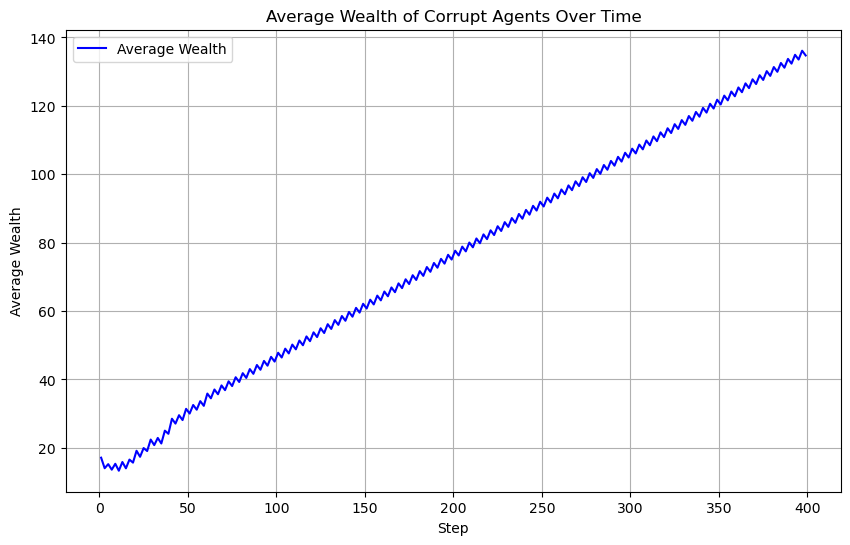

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Average Wealth"], label="Average Wealth", color="blue")
plt.xlabel("Step")
plt.ylabel("Average Wealth")
plt.title("Average Wealth of Corrupt Agents Over Time")
plt.legend()
plt.grid(True)
plt.show()

Survival Rate

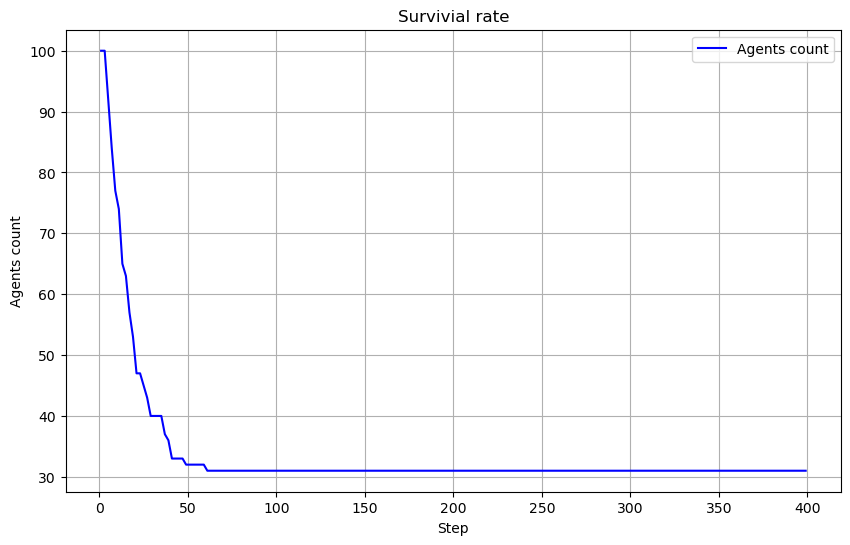

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Agents"], label="Agents count", color="blue")
plt.xlabel("Step")
plt.ylabel("Agents count")
plt.title("Survivial rate")
plt.legend()
plt.grid(True)
plt.show()

# Data collection

# Retrieve the data collected by the DataCollector
agent_data = model1.datacollector.get_agent_vars_dataframe()
mean_data = agent_data.groupby("Step").mean().reset_index()

#100th step data
step_100_data = agent_data.xs(100, level="Step")

#GroupBy bins in blocks of 100
bins = range(0, 210, 10)
step_100_data.loc[:, "Eaten Bins"] = pd.cut(step_100_data["Total Eaten"], bins=bins, right=False)
step_100_data.loc[:, "Shared Bins"] = pd.cut(step_100_data["Total Shared"], bins=bins, right=False)

grouped_eaten = step_100_data.groupby("Eaten Bins")["Wealth"].mean().reset_index()
grouped_shared = step_100_data.groupby("Shared Bins")["Wealth"].mean().reset_index()

# Extract Collection Efficiency and Wealth for step 100
collection_efficiency = agent_data["Collection Efficiency"]
wealth = agent_data["Wealth"]

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Collection Efficiency", y="Wealth")
plt.title('Collection Efficiency vs Wealth at Step 100')
plt.savefig("Plots/Non_corrupt/Wealth/efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Consumption", y="Wealth")
plt.title('Consumption (Metabolism) vs Wealth at Step 100')
plt.savefig("Plots/Non_corrupt/Wealth/consumption.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Wealth")
plt.title('Wealth vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Non_corrupt/Wealth/toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Wealth")
plt.title('Wealth vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Non_corrupt/Wealth/totshared.png")

agent_data.loc[:, "Eaten Bins"] = pd.cut(agent_data["Total Eaten"], bins=bins, right=False)
agent_data.loc[:, "Shared Bins"] = pd.cut(agent_data["Total Shared"], bins=bins, right=False)

grouped_eaten = agent_data.groupby("Eaten Bins")["Survival"].mean().reset_index()
grouped_shared = agent_data.groupby("Shared Bins")["Survival"].mean().reset_index()

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Collection Efficiency", y="Survival")
plt.title('Collection Efficiency vs Survival')
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Consumption", y="Survival")
plt.title('Consumption (Metabolism) vs Survival')
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_consumption.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Survival")
plt.title('Survival vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Survivial')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Survival")
plt.title('Survivla vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Survival')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_totshared.png")

In [1]:
from mesa.visualization.UserParam import UserSettableParameter
# Portrayal function for visualization
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.2}

    if isinstance(agent, Sugar):
        portrayal["Color"] = "green"
        portrayal["Layer"] = 0
        portrayal["r"] = agent.curr_amount / 30  # Scale size based on sugar amount
    elif isinstance(agent, Non_corrupt_agent):
        portrayal["Color"] = "blue"
        portrayal["Layer"] = 1
        #portrayal["r"] = agent.sugar_agent / 30  # Scale size based on agent's sugar
        portrayal["text"] = str(agent.sugar_agent)  # Display the unique_id as text
        portrayal["text_color"] = "black"  # Set the color of the text

    return portrayal

agent_count_element = AgentCountElement()
average_wealth_element = AverageWealthElement()

# CanvasGrid for visualization
grid = CanvasGrid(agent_portrayal, 50, 50, 500, 500)

# ChartModule for visualizing data
chart = ChartModule([{"Label": "Non_corrupt_agents",
                      "Color": "Red"},
                     {"Label": "Sugar",
                      "Color": "Green"}],
                    data_collector_name='datacollector')

# Setting up the server
server = ModularServer(Model,
                       [grid, agent_count_element, average_wealth_element],
                       "Sugar Model",
                       {"X": 50, "Y": 50, "init_population": 100, "init_resource_min": 25, "init_resource_max": 50,
                        "metabolism_min": 1, "metabolism_max": 5, "vision_min": 1, "vision_max": 5, "seed": global_seed})

# Launch the server
server.port = 8522  # The default
server.launch()

ImportError: cannot import name 'UserSettableParameter' from 'mesa.visualization.UserParam' (C:\Users\DELL\anaconda3\Lib\site-packages\mesa\visualization\UserParam.py)